In [2]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [3]:
import os

path ='/home/oltrajordi27/data2/validation'
patients = os.listdir(path)
len(patients)

40

In [4]:
os.listdir(f'{path}/{patients[0]}')

['200_LA_ES.nii.gz',
 '200_SA_ES.nii.gz',
 '200_LA_ED.nii.gz',
 '200_LA_CINE.nii.gz',
 '200_SA_CINE.nii.gz',
 '200_SA_ED.nii.gz']

In [13]:
import shutil

dest = 'preds'
#shutil.rmtree(dest)   #para borrar carpetas
os.makedirs(dest)

In [14]:
max_val = {
    'LA_ED': 4104.,
    'LA_ES': 7875.,
    'SA_ED': 11510.,
    'SA_ES': 9182.,
}

In [15]:
import albumentations as A

resize = A.Resize(224,224)

In [16]:
import nibabel as nib

def pred_la(patient, file):
    img = nib.load(f'{path}/{patient}/{patient}_{file}.nii.gz')
    img_data = img.get_fdata()/ max_val[file]
    resized = resize(image=img_data[...,0])['image']
    img_t = torch.from_numpy(resized).float().unsqueeze(0)
    output = model.predict(img_t.unsqueeze(0)) #.cuda()
    output = torch.sigmoid(output)
    mask = torch.argmax(output[0,...],axis=0).float().cpu().numpy()
    mask_resized = np.rint(A.Resize(*img.shape)(image=mask)['image'])[...,None]
    nib.save(nib.Nifti1Image(mask_resized, img.affine),f'{dest}/{patient}_{file}_pred.nii.gz')
    
def pred_sa(patient, file):
    img = nib.load(f'{path}/{patient}/{patient}_{file}.nii.gz')
    img_data = img.get_fdata()/ max_val[file]
    resized = resize(image=img_data)['image']
    img_t = torch.from_numpy(resized).float().permute(2,0,1).unsqueeze(1)
    output = model.predict(img_t) #.cuda()
    output = torch.sigmoid(output)
    masks = torch.argmax(output,axis=1).float().cpu().permute(1,2,0).numpy()
    mask_resized = np.rint(A.Resize(*img.shape[:2])(image=masks)['image'])
    nib.save(nib.Nifti1Image(mask_resized, img.affine),f'{dest}/{patient}_{file}_pred.nii.gz')

In [17]:
import numpy as np
patients = np.array(patients)

In [18]:
from tqdm import tqdm

for patient in tqdm(patients):
    os.makedirs(f'{dest}/{patients}', exist_ok = True)
    pred_la(patient, 'LA_ED')
    pred_la(patient, 'LA_ES')
    pred_sa(patient, 'SA_ED')
    pred_sa(patient, 'SA_ES')

100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


In [19]:
img = nib.load(f'{path}/{patient}/200_LA_ES.nii.gz')
img_data = img.get_fdata()/ max_val['LA_ES']
resized = resize(image=img_data)['image']
img_t = torch.from_numpy(resized).float().permute(2,0,1).unsqueeze(1)
output = model.predict(img_t) #.cuda()
output = torch.sigmoid(output)
masks = torch.argmax(output,axis=1).float().cpu().permute(1,2,0).numpy()
mask_resized = np.rint(A.Resize(*img.shape[:2])(image=masks)['image'])

FileNotFoundError: No such file or no access: '/home/oltrajordi27/data2/validation/186/200_LA_ES.nii.gz'

In [62]:
output.size()

torch.Size([1, 4, 224, 224])

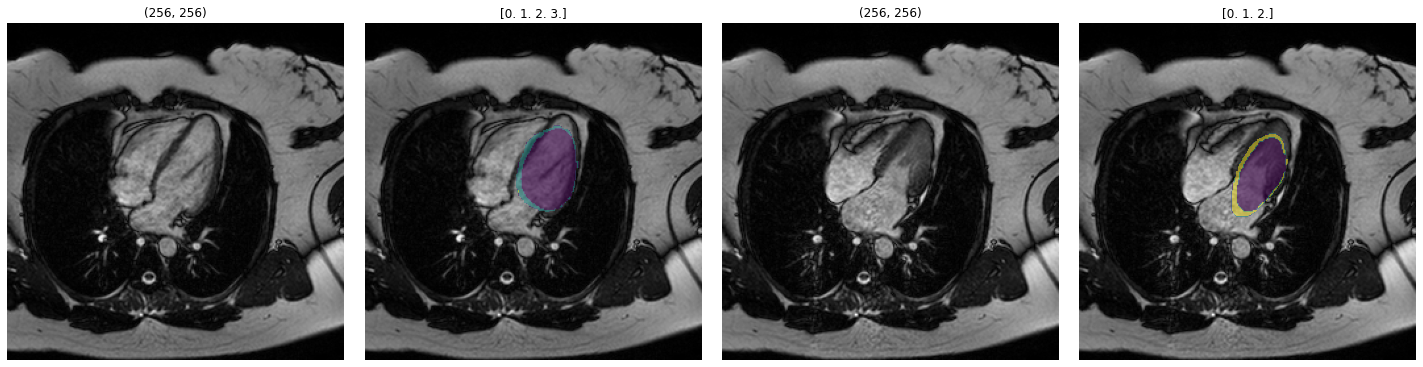

In [25]:
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(patients))
sample = patients[ix]
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(1, 4, 1)
image_path = f'{path}/{sample}/{sample}_LA_ED.nii.gz'
img = nib.load(image_path).get_fdata()[...,0]
ax.imshow(img,cmap='gray')
ax.axis('off')
ax.set_title(img.shape)
ax = plt.subplot(1, 4, 2)
image_path = f'{dest}/{sample}_LA_ED_pred.nii.gz'
mask = nib.load(image_path).get_fdata()[...,0]
ax.imshow(img, cmap='gray')
ax.set_title(np.unique(mask))
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
ax.axis('off')
ax = plt.subplot(1, 4, 3)
image_path = f'{path}/{sample}/{sample}_LA_ES.nii.gz'
img = nib.load(image_path).get_fdata()[...,0]
ax.imshow(img,cmap='gray')
ax.axis('off')
ax.set_title(img.shape)
ax = plt.subplot(1, 4, 4)
image_path = f'{dest}/{sample}_LA_ES_pred.nii.gz'
mask = nib.load(image_path).get_fdata()[...,0]
ax.imshow(img, cmap='gray')
ax.set_title(np.unique(mask))
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
ax.axis('off')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


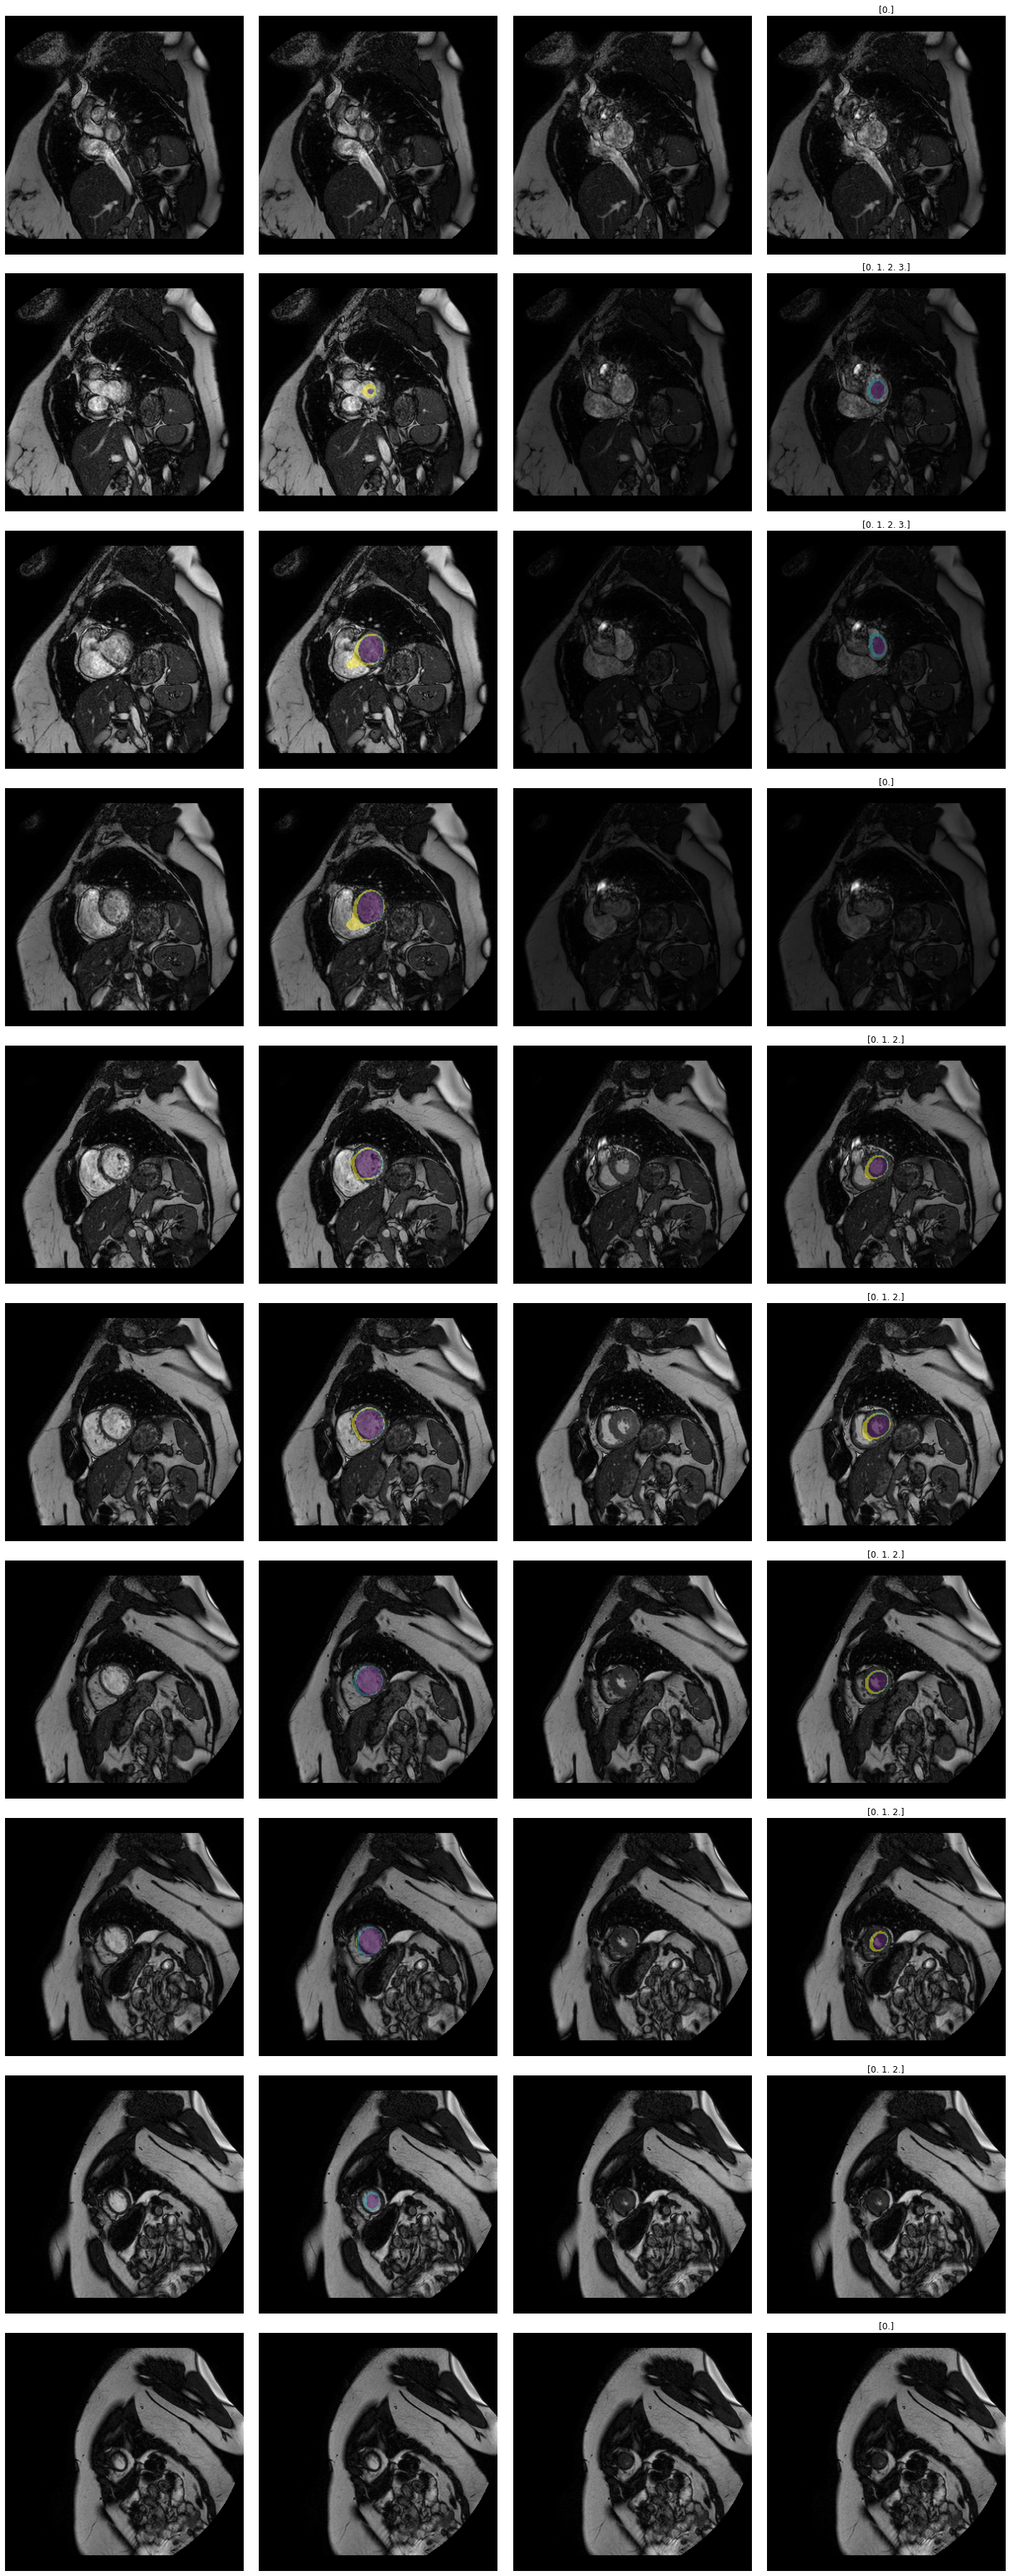

In [28]:
ed_img = nib.load(f'{path}/{sample}/{sample}_SA_ED.nii.gz').get_fdata()
channels = ed_img.shape[-1]

ed_pred = nib.load(f'{dest}/{sample}_SA_ED_pred.nii.gz').get_fdata()
es_img = nib.load(f'{path}/{sample}/{sample}_SA_ES.nii.gz').get_fdata()
es_pred = nib.load(f'{dest}/{sample}_SA_ES_pred.nii.gz').get_fdata()

fig = plt.figure(figsize=(20, channels*5))
for c in range(channels):
    ax = plt.subplot(channels, 4, 4*c + 1)
    ax.imshow(ed_img[...,c],cmap='gray')
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 2)
    ax.imshow(ed_img[...,c], cmap='gray')
    mask = ed_pred[...,c]
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 3)
    ax.imshow(es_img[...,c],cmap='gray')
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 4)
    ax.imshow(es_img[...,c],cmap='gray')
    mask = es_pred[...,c]
    ax.set_title(np.unique(mask))
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()